In [1]:
import pandas as pd
import os
import re
from datetime import datetime, timedelta
import cv2
import numpy as np
import matplotlib.pyplot as plt
from image_points import *
%matplotlib inline


In [2]:
directory = '../../data/labels'
pattern = re.compile(r'screenshot(\d+)_(\d{2})_(\d{2})__(\d{2})_(\d{2})\.txt')
df = pd.DataFrame(columns=['Camera', 'Date', 'X_center', 'Y_center', 'Width', 'Height'])
numeric_cols = ['Camera', 'X_center', 'Y_center', 'Width', 'Height']


csv_file = 'positions.csv'
if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)
else:
    for filename in os.listdir(directory):
        # print(filename)
        path = os.path.join(directory, filename)
        match = pattern.match(filename)
        assert match
        camera, day, month, hour, minute = map(int, match.groups())
        # Convert to datetime object
        data = {}
        timestamp = pd.Timestamp(year=2024, month=month, day=day, hour=hour, minute=minute)
        with open(path) as file:
            for item in file:
                _, x_center, y_center, width, height = item.strip().split()
                data['X_center'], data['Y_center'], data['Width'], data['Height'] = x_center, y_center, width, height
                data['Camera'] = camera
                data['Date'] = pd.to_datetime(timestamp)
                df = pd.concat([df, pd.DataFrame([data])], ignore_index=True)
    
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col])
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'] + pd.Timedelta(hours=1)
df.to_csv('positions.csv', index=False)


    
        

In [3]:
def get_heatmap(df, camera):
    df = df[df['Camera'] == camera]

    # Specify the dimensions of the heatmap
    heatmap_width, heatmap_height = 1920, 1000

    # Initialize a blank image for the heatmap
    heatmap_img = np.zeros((heatmap_height, heatmap_width), dtype=np.float32)

    # Function to apply intensity within the bounding box area
    def apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap):
        # Calculate the bounding box in pixel coordinates
        left = int(max(0, cx - w * heatmap_width / 2))
        right = int(min(heatmap_width, cx + w * heatmap_width / 2))
        top = int(max(0, cy - h * heatmap_height / 2))
        bottom = int(min(heatmap_height, cy + h * heatmap_height / 2))

        sigma_x = w * heatmap_width / 6
        sigma_y = h * heatmap_height / 6

        # Apply intensity only within the bounding box, using a Gaussian distribution
        for y in range(top, bottom):
            for x in range(left, right):
                dx = cx - x
                dy = cy - y
                value = np.exp(-(dx ** 2 / (2 * sigma_x ** 2) + dy ** 2 / (2 * sigma_y ** 2)))
                heatmap[y, x] += value

    # Populate the heatmap with bounded Gaussian distribution
    for index, row in df.iterrows():
        cx, cy, w, h = row['X_center'] * heatmap_width, row['Y_center'] * heatmap_height, row['Width'], row['Height']
        apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap_img)

    # Normalize the heatmap
    cv2.normalize(heatmap_img, heatmap_img, 0, 255, norm_type=cv2.NORM_MINMAX)
    zero_mask = (heatmap_img < 20)
    # Apply a colormap to create a color heatmap
    heatmap_color = cv2.applyColorMap(np.uint8(heatmap_img), cv2.COLORMAP_JET)
    heatmap_color[zero_mask] = (0,0,0)
    # plt.figure()
    # plt.imshow(heatmap_color[..., ::-1])  # change channels order since the YOLO work on BGR images
    # plt.show()
    return heatmap_color

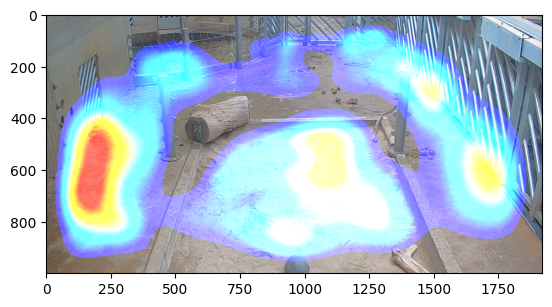

In [4]:
# Optionally, load an actual image to overlay the heatmap on
original_img = cv2.imread('backgrounds/background1.png')
heatmap_color = get_heatmap(df, 1)
overlayed_img = cv2.addWeighted(original_img, 1, heatmap_color, 1, 0)
plt.figure()
plt.imshow(overlayed_img[..., ::-1])  # change channels order since the YOLO work on BGR images
plt.show()


In [5]:
cv2.imwrite('heat.png', overlayed_img)

True

In [6]:
# camera_to_path = {
#     1: 'data/images/screenshot1_01_02__11_15.png',
#     2: 'data/images/screenshot2_04_02__13_15.png',
#     4: 'data/images/screenshot4_05_02__14_30.png',
#     6: 'data/images/screenshot6_28_01__15_15.png',
#     7: 'data/images/screenshot7_29_01__15_15.png'}
# for key in camera_to_path.keys():
#     heatmap_color = get_heatmap(df, key)
#     original_img = cv2.imread(camera_to_path[key])
#     overlayed_img = cv2.addWeighted(original_img, 1, heatmap_color, 1, 0)
#     plt.figure()
#     plt.imshow(overlayed_img[..., ::-1])  # change channels order since the YOLO work on BGR images
#     plt.show()


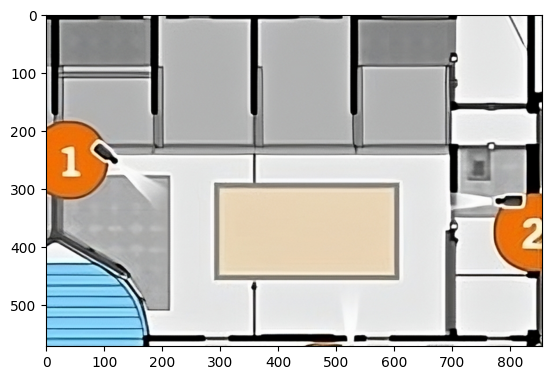

In [7]:
def show(img):
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # change channels order since the YOLO work on BGR images
background = cv2.imread('back.jpeg')

show(background)

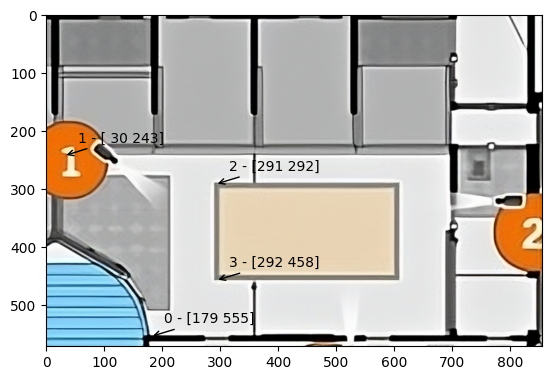

In [8]:
background = cv2.imread('back.jpeg')
show(background)
for i, pt in enumerate(MAP_PTS_1):
    plt.annotate(str(i) + " - " + str(pt), xy=pt, textcoords="offset points", xytext=(10,10), arrowprops=dict(arrowstyle="->"))

In [9]:
image_pts = [(85, 56), (344, 13), (340, 88), (155, 96)]
air_pts = [(178, 551), (30, 243), (291, 292), (292, 460)]
H, mask = cv2.findHomography(np.array(image_pts), np.array(air_pts))
print(H)

[[ 1.26774648e-01  5.78395911e+00 -8.68939492e+01]
 [-1.51578275e+00  2.69704714e+00  7.44822439e+02]
 [-8.45288316e-05  7.12906574e-03  1.00000000e+00]]


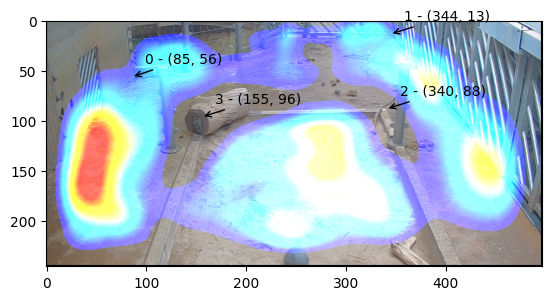

In [10]:
img = cv2.imread('output.png')
show(img)
for i, pt in enumerate(image_pts):
    plt.annotate(str(i) + " - " + str(pt), xy=pt, textcoords="offset points", xytext=(10,10), arrowprops=dict(arrowstyle="->"))

572 856


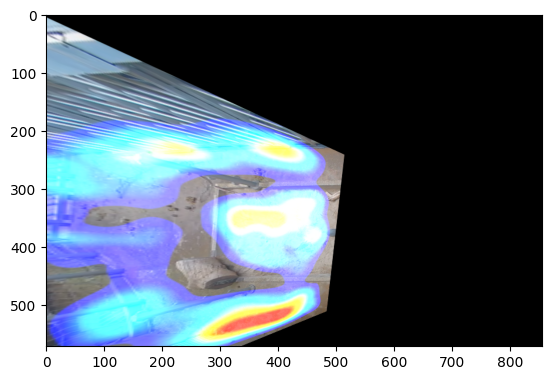

In [11]:
height, width = background.shape[:2]
print(height, width)
dst = cv2.warpPerspective(img, H, (width, height))
show(dst)


In [12]:
def get_heatmap_new(df, camera):
    df = df[df['Camera'] == camera]

    # Specify the dimensions of the heatmap
    heatmap_width, heatmap_height = 856, 572

    # Initialize a blank image for the heatmap
    heatmap_img = np.zeros((heatmap_height, heatmap_width), dtype=np.float32)

    # Function to apply intensity within the bounding box area
    def apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap):
        # Calculate the bounding box in pixel coordinates
        left = int(max(0, cx - w * heatmap_width / 2))
        right = int(min(heatmap_width, cx + w * heatmap_width / 2))
        top = int(max(0, cy - h * heatmap_height / 2))
        bottom = int(min(heatmap_height, cy + h * heatmap_height / 2))

        sigma_x = w * heatmap_width / 6
        sigma_y = h * heatmap_height / 6

        # Apply intensity only within the bounding box, using a Gaussian distribution
        for y in range(top, bottom):
            for x in range(left, right):
                dx = cx - x
                dy = cy - y
                value = np.exp(-(dx ** 2 / (2 * sigma_x ** 2) + dy ** 2 / (2 * sigma_y ** 2)))
                heatmap[y, x] += value

    # Populate the heatmap with bounded Gaussian distribution
    for index, row in df.iterrows():
        cx, cy, w, h = row['X_center_prime'] * heatmap_width, row['Y_center_prime'] * heatmap_height, row['Width_prime'], row['Height_prime']
        apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap_img)

    # Normalize the heatmap
    cv2.normalize(heatmap_img, heatmap_img, 0, 255, norm_type=cv2.NORM_MINMAX)
    zero_mask = (heatmap_img < 20)
    # Apply a colormap to create a color heatmap
    heatmap_color = cv2.applyColorMap(np.uint8(heatmap_img), cv2.COLORMAP_JET)
    heatmap_color[zero_mask] = (0,0,0)
    # plt.figure()
    # plt.imshow(heatmap_color[..., ::-1])  # change channels order since the YOLO work on BGR images
    # plt.show()
    return heatmap_color

In [13]:
def transform_row(M, x, y, width, height):
    x, y = x*1920, y*1000
    width, height = width*1920, height*1000
    def transform_point(M, x, y):
        x_prime = (M[0, 0] * x + M[0, 1] * y + M[0, 2]) / (M[2, 0] * x + M[2, 1] * y + M[2, 2])
        y_prime = (M[1, 0] * x + M[1, 1] * y + M[1, 2]) / (M[2, 0] * x + M[2, 1] * y + M[2, 2])
        return x_prime, y_prime
    x_prime, y_prime = transform_point(M, x, y)
    
    left, right = x - width/2, x + width/2
    left_prime = transform_point(M, left, y)
    right_prime = transform_point(M, right, y)
    width_prime = np.linalg.norm(np.array(left_prime)-np.array(right_prime))
    up, down = y - height/2, y + height/2
    up_prime = transform_point(M, x, up)
    down_prime = transform_point(M, x, down)
    height_prime = np.linalg.norm(np.array(up_prime)-np.array(down_prime))
    return x_prime/856, y_prime/572, width_prime/856, height_prime/572


In [14]:
df_new = pd.DataFrame(columns=['Camera', 'Date', 'X_center_prime', 'Y_center_prime', 'Width_prime', 'Height_prime'])
sub = df[df['Camera'] == 1]
for index, row in sub.iterrows():
    data = {}
    data['Camera'] = 1
    data['Date'] = row['Date']
    data['X_center_prime'], data['Y_center_prime'], data['Width_prime'], data['Height_prime'] = transform_row(H, row['X_center'], row['Y_center'], row['Width'], row['Height'])
    # print(data)
    df_new = pd.concat([df_new, pd.DataFrame([data])], ignore_index=True)
df_new

/tmp/ipykernel_451419/1268758156.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_new = pd.concat([df_new, pd.DataFrame([data])], ignore_index=True)


,Camera,Date,X_center_prime,Y_center_prime,Width_prime,Height_prime
0,1,2024-01-24 14:15:00,0.801059,-0.101949,0.228232,0.762682
1,1,2024-01-24 14:15:00,0.706329,-0.445670,0.248663,1.288137
2,1,2024-01-27 04:15:00,0.816535,0.272526,0.141199,0.327395
3,1,2024-01-27 04:15:00,0.782358,0.309691,0.211362,0.214449
4,1,2024-01-27 04:00:00,0.816903,0.269256,0.137610,0.322651
...,...,...,...,...,...,...
388,1,2024-01-27 07:00:00,0.450327,-0.888511,0.196303,1.385118
389,1,2024-01-27 07:00:00,0.432299,-0.644614,0.161468,1.348278
390,1,2024-01-27 04:30:00,0.821678,0.324190,0.139368,0.215573
391,1,2024-01-27 04:30:00,0.781376,0.386801,0.106532,0.182341


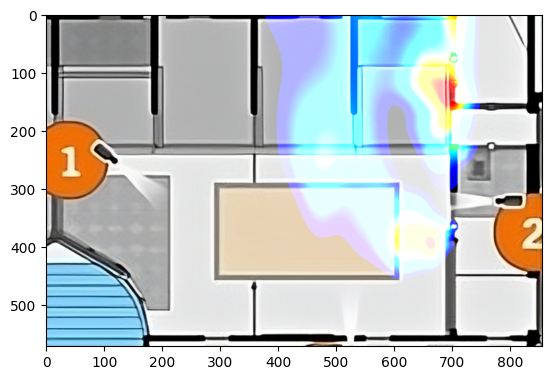

In [15]:
# Optionally, load an actual image to overlay the heatmap on
original_img = cv2.imread('back.jpeg')
heatmap_color = get_heatmap_new(df_new, 1)
overlayed_img = cv2.addWeighted(original_img, 1, heatmap_color, 1, 0)
plt.figure()
plt.imshow(overlayed_img[..., ::-1])  # change channels order since the YOLO work on BGR images
plt.show()


In [16]:
df[df['Camera'] == 1]

,Camera,Date,X_center,Y_center,Width,Height
22,1,2024-01-24 14:15:00,0.840104,0.5300,0.308333,0.524
23,1,2024-01-24 14:15:00,0.779948,0.2885,0.209896,0.365
36,1,2024-01-27 04:15:00,0.597135,0.7150,0.249479,0.562
37,1,2024-01-27 04:15:00,0.485677,0.5800,0.315104,0.334
112,1,2024-01-27 04:00:00,0.601302,0.7155,0.243229,0.553
...,...,...,...,...,...,...
2799,1,2024-01-27 07:00:00,0.616146,0.0935,0.087500,0.155
2800,1,2024-01-27 07:00:00,0.541667,0.0930,0.072917,0.168
2822,1,2024-01-27 04:30:00,0.560156,0.7665,0.261979,0.465
2823,1,2024-01-27 04:30:00,0.415885,0.6000,0.164062,0.340


In [17]:
def draw_circle_at_relative_position(image, rel_x, rel_y, radius=10, color=(0, 255, 0), thickness=2):
    """
    Draw a small circle on the image at a relative position.

    Parameters:
    - image: The image on which to draw the circle (numpy array).
    - rel_x: The relative x coordinate (from 0 to 1) where to draw the circle.
    - rel_y: The relative y coordinate (from 0 to 1) where to draw the circle.
    - radius: The radius of the circle (in pixels).
    - color: The color of the circle (B, G, R) format.
    - thickness: The thickness of the circle's outline. Use a negative value for a filled circle.
    """
    # Calculate actual pixel coordinates
    height, width = image.shape[:2]
    print(width)
    center_x = int(rel_x * width)
    center_y = int(rel_y * height)

    # Draw the circle
    cv2.circle(image, (center_x, center_y), radius, color, thickness)
    return image
def draw_circle_at_exact_position(image, x, y, radius=10, color=(0, 255, 0), thickness=2):
    """
    Draw a small circle on the image at a relative position.

    Parameters:
    - image: The image on which to draw the circle (numpy array).
    - rel_x: The relative x coordinate (from 0 to 1) where to draw the circle.
    - rel_y: The relative y coordinate (from 0 to 1) where to draw the circle.
    - radius: The radius of the circle (in pixels).
    - color: The color of the circle (B, G, R) format.
    - thickness: The thickness of the circle's outline. Use a negative value for a filled circle.
    """
    # Calculate actual pixel coordinates# Draw the circle
    cv2.circle(image, (int(x), int(y)), radius, color, thickness)
    return image
    

In [18]:
def transform_point(M, x, y):
    x_prime = (M[0, 0] * x + M[0, 1] * y + M[0, 2]) / (M[2, 0] * x + M[2, 1] * y + M[2, 2])
    y_prime = (M[1, 0] * x + M[1, 1] * y + M[1, 2]) / (M[2, 0] * x + M[2, 1] * y + M[2, 2])
    return x_prime, y_prime


In [19]:
transform_point(H,  0.69*1920,	0.4200*1000)

(646.619064608079, -33.621646261143326)